In [1]:
!nvidia-smi

Sat Mar 25 00:06:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers datasets evaluate wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 7.6 MB/s eta 0:00

## Load Data and Libraries

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from transformers import ViTFeatureExtractor, ViTForImageClassification, AutoFeatureExtractor, ResNetForImageClassification
from transformers import TrainingArguments, Trainer
from datasets import load_metric, DatasetDict, Dataset, load_dataset

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import wandb
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

In [4]:
wandb.login()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!mkdir /content/drive/MyDrive/lsd/data2

In [ ]:
!unzip '/content/drive/MyDrive/lsd/llsd_kmean.zip' -d '/content/wandb/'

In [30]:
datasets = load_dataset('imagefolder', data_dir='/content/wandb/llsd_kmean')
datasets = datasets['train'].train_test_split(test_size=.2, seed=42)

datasets_split = datasets['train'].train_test_split(test_size=.2, seed=42)
datasets['train'] = datasets_split['train']
datasets['validation'] = datasets_split['test']

datasets

Resolving data files:   0%|          | 0/975 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-1bcc46b3257347cf/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 195
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

In [31]:
# datasets = load_dataset('imagefolder', data_dir='/content/drive/MyDrive/lsd/lsdd')

In [32]:
datasets

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 195
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

In [33]:
labels = datasets['train'].features['label'].names
labels

['Lumpy Skin', 'Normal Skin']

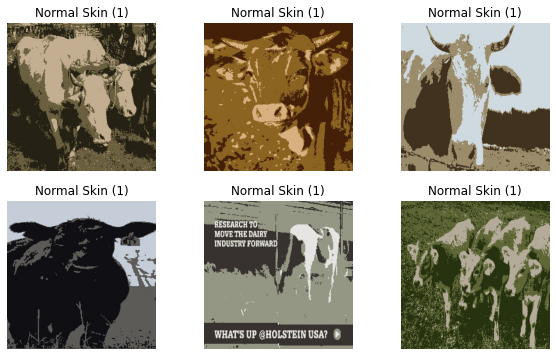

In [34]:
# plot samples
samples = datasets['train'].select(range(6))
pointer = 0

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(samples[pointer]['image'])
        ax[i,j].set_title(f"{labels[samples[pointer]['label']]} ({samples[pointer]['label']})")
        ax[i,j].axis('off')
        pointer+=1

plt.show()

## ViT - Vision Transformer

In [35]:
model_ckpt = 'google/vit-base-patch16-224-in21k'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [37]:
extractor(samples[0]['image'], return_tensors='pt')
# there are a lot of ones bcs the background of imgs are white, so its normal

{'pixel_values': tensor([[[[-0.7098, -0.5686, -0.3804,  ..., -0.4039, -0.2549, -0.1529],
          [-0.6784, -0.5529, -0.3255,  ..., -0.1686, -0.1529, -0.1373],
          [-0.6941, -0.5451, -0.1686,  ...,  0.0039, -0.0902, -0.3020],
          ...,
          [-0.3490, -0.2784, -0.3725,  ..., -0.1686, -0.3255, -0.2078],
          [-0.4902, -0.2157, -0.2784,  ..., -0.2941, -0.1765, -0.1686],
          [-0.6627, -0.5922, -0.4353,  ..., -0.2078, -0.4588, -0.5843]],

         [[-0.7569, -0.6235, -0.4431,  ..., -0.4824, -0.3490, -0.2627],
          [-0.7490, -0.6157, -0.3804,  ..., -0.2549, -0.2549, -0.2549],
          [-0.7647, -0.6078, -0.2314,  ..., -0.0824, -0.1922, -0.4275],
          ...,
          [-0.4039, -0.3333, -0.4118,  ..., -0.2392, -0.3882, -0.2784],
          [-0.5529, -0.2706, -0.3333,  ..., -0.3725, -0.2549, -0.2471],
          [-0.7333, -0.6627, -0.4980,  ..., -0.2941, -0.5451, -0.6706]],

         [[-0.7804, -0.7098, -0.6000,  ..., -0.7490, -0.6078, -0.4745],
          [-0

In [38]:
def batch_transform(examples):
    # take a list of PIL images and turn into pixel values
    inputs = extractor([x for x in examples['image']], return_tensors='pt')
    # add the labels in
    inputs['label'] = examples['label']
    
    return inputs

In [39]:
transformed_data = datasets.with_transform(batch_transform)
transformed_data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 195
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

In [40]:
# data collator
def collate_fn(examples):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in examples]),
        'labels': torch.tensor([x['label'] for x in examples])
    }

# metrics
metric = load_metric('accuracy')
def compute_metrics(p):
    labels = p.label_ids
    preds = p.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1
    }
#     return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

### Zero-shot

In [41]:
model = ViTForImageClassification.from_pretrained(model_ckpt,
                                                 num_labels=len(labels),
                                                 id2label={str(i): c for i, c in enumerate(labels)},
                                                 label2id={c: str(i) for i, c in enumerate(labels)})
model = model.to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
zero_loader = DataLoader(transformed_data['test'], batch_size=16)
zero_pred = []
for batch in tqdm(zero_loader):
    with torch.no_grad():        
        logits = model(batch['pixel_values'].to(device)).logits
        pred = logits.argmax(-1).cpu().detach().tolist()
        zero_pred += [labels[i] for i in pred]

  0%|          | 0/13 [00:00<?, ?it/s]

In [43]:
zero_true = [labels[i] for i in datasets['test']['label']]

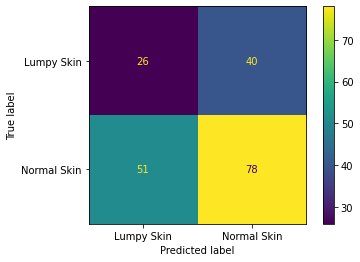

In [44]:
cm = confusion_matrix(zero_true, zero_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.show()

In [45]:
print(f'ViT zero-shot Acc: {accuracy_score(zero_true, zero_pred):.3f}')
print(f'ViT zero-shot F1: {f1_score(zero_true, zero_pred, average="weighted"):.3f}')

ViT zero-shot Acc: 0.533
ViT zero-shot F1: 0.541


### Fine Tuning

In [46]:
vit_config = dict(learning_rate = 1e-5,
                  architecture = 'ViT',
                  dataset_id = 'lsd',
                  infra='kaggle')

run = wandb.init(project='lssd',
                notes='SMLT course project',
                tags=['comparison', 'ViT', 'ResNet'],                 
                config=vit_config,
                name='hf-ViT-base-16-224')

eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.76282


In [47]:
# train props
batch_size = 16
logging_steps = len(transformed_data['train']) // batch_size

In [48]:
training_args = TrainingArguments(output_dir='/content/wandb',
                                 report_to='wandb',
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 evaluation_strategy='epoch',
                                 save_strategy='epoch',
                                 num_train_epochs=10,
                                 fp16=True if torch.cuda.is_available() else False,
                                 logging_steps=logging_steps,
                                 learning_rate=1e-5,
                                 save_total_limit=2,
                                 remove_unused_columns=False,
                                 push_to_hub=False,
                                 load_best_model_at_end=True)

In [49]:
trainer = Trainer(model=model,
                 args=training_args,
                 data_collator=collate_fn,
                 compute_metrics=compute_metrics,
                 train_dataset=transformed_data['train'],
                 eval_dataset=transformed_data['validation'],
                 tokenizer=extractor)

In [50]:
train_result = trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.590500,0.490032,0.750000,0.642857
2,0.419500,0.369426,0.878205,0.863167
3,0.299600,0.307190,0.916667,0.914684
4,0.217600,0.272689,0.903846,0.903426
5,0.163700,0.257879,0.897436,0.899749
6,0.130500,0.245238,0.903846,0.905693
7,0.107300,0.234812,0.903846,0.905693
8,0.091600,0.247601,0.903846,0.906323
9,0.083200,0.246985,0.903846,0.906323
10,0.079100,0.245124,0.910256,0.912281


In [51]:
trainer.evaluate(transformed_data['validation'])

{'eval_loss': 0.23481163382530212,
 'eval_accuracy': 0.9038461538461539,
 'eval_f1': 0.9056926395538486,
 'eval_runtime': 1.5603,
 'eval_samples_per_second': 99.984,
 'eval_steps_per_second': 6.409,
 'epoch': 10.0}

In [52]:
predictions = trainer.predict(transformed_data['test'])
predictions.metrics

{'test_loss': 0.26702067255973816,
 'test_accuracy': 0.9025641025641026,
 'test_f1': 0.9019911034345678,
 'test_runtime': 1.9939,
 'test_samples_per_second': 97.801,
 'test_steps_per_second': 6.52}

In [53]:
run.finish()

eval/accuracy,▁▆█▇▇▇▇▇▇█▇
eval/f1,▁▇█████████
eval/loss,█▅▃▂▂▁▁▁▁▁▁
eval/runtime,▁▁▁▁▆▇█▁▂▂▅
eval/samples_per_second,███▇▃▂▁█▇▇▃
eval/steps_per_second,███▇▃▂▁█▇▇▃
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇████
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇████
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▆▄▃▂▂▁▁▁▁
train/total_flos,▁


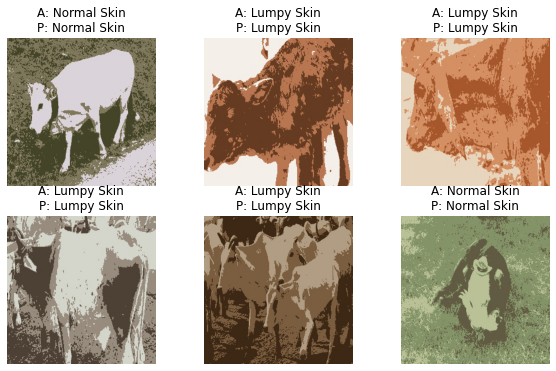

In [54]:
# plot samples
samples = datasets['test'].select(range(6))
pointer = 0

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(samples[pointer]['image'])
        ax[i,j].set_title(f"A: {labels[samples[pointer]['label']]}\nP: {labels[predictions.label_ids[pointer]]}")
        ax[i,j].axis('off')
        pointer+=1

plt.show()